# Module 4 - Non linear modeling

# Outcome

The metric used to choose one model over another was the average_precision_score (AP), given that this is an imbalanced problem. Starting with the Ridge linear model as a baseline with the best AP, comparisons were made with nonlinear models such as decision trees, random forests, XGBoost, and CatBoost. For each of these models, the process included:

- Hyperparameter tuning with all features included.
- Selection of the best configuration based on AP.
- Feature importance analysis for the selected configuration.
- Hyperparameter tuning using only the previously identified important features.
- Final selection of the best configuration.

After selecting the best configuration for each type of nonlinear model, precision-recall curves were plotted for all of them, and the best-performing model was chosen. This final model was then applied to the test subset, and its confusion matrix was calculated for a specific threshold.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    roc_curve,
    roc_auc_score,
    average_precision_score,
)
from sklearn.metrics import confusion_matrix
import random
from catboost import CatBoostClassifier, Pool

In [2]:
data = pd.read_csv(r"/home/raquel/zrive-ds/src/module_3/feature_frame.csv")

In [3]:
# Orders with more than 5 products
purchases = data[data["outcome"] == 1]
purchases = purchases.groupby("order_id").size().reset_index(name="n_products")
purch_5_prod = purchases[purchases["n_products"] >= 5]

The previous DataFrame contains the products purchased in each of the orders with more than 5 products. I complete the dataset with those products that have NOT been purchased in these baskets

In [4]:
purch_5_prod = data[data["order_id"].isin(purch_5_prod["order_id"])]
print(purch_5_prod.shape)

(2163953, 27)


In [5]:
# For a recommendation algorithm, I think it could be useful to create a feature that extracts the month of the purchase.
purch_5_prod = purch_5_prod.assign(
    created_at=lambda x: pd.to_datetime(x.created_at),
    month_created=lambda x: x.created_at.dt.month,
    order_date=lambda x: pd.to_datetime(x.order_date),
)
purch_5_prod.head(2)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,month_created
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,10
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,10


# Train-Val-Test split

Im'm going to do a common train-val-test split for all the models. 
- The train subset for ensemble learning will be divided as corresponds in each model.
- The validation subset will be the tool to identify overfitting.
- The test subset will be the final proof.

In [6]:
# To avoid information leakage, I will follow the chronological order and all products from the same order within the same subset
daily_orders = purch_5_prod.groupby("order_date").order_id.nunique()
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()

train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.9].idxmax()

print("Train since", cumsum_daily_orders.index.min())
print("Train until", train_val_cutoff)
print("Val until", val_test_cutoff)
print("Test until", cumsum_daily_orders.index.max())

Train since 2020-10-05 00:00:00
Train until 2021-02-04 00:00:00
Val until 2021-02-22 00:00:00
Test until 2021-03-03 00:00:00


In [7]:
train_df = purch_5_prod[purch_5_prod.order_date <= train_val_cutoff]
val_df = purch_5_prod[
    (purch_5_prod.order_date > train_val_cutoff)
    & (purch_5_prod.order_date <= val_test_cutoff)
]
test_df = purch_5_prod[purch_5_prod.order_date > val_test_cutoff]

In [8]:
# Without predictive power
info_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
label_col = "outcome"
feature_cols = [
    col for col in purch_5_prod.columns if col not in info_cols + [label_col]
]
# Breaking down the features
categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [
    col for col in feature_cols if col not in categorical_cols + binary_cols
]
train_cols = numerical_cols + binary_cols

In [9]:
X_train = train_df.drop(label_col, axis=1)
y_train = train_df[label_col]
X_val = val_df.drop(label_col, axis=1)
y_val = val_df["outcome"]
X_test = test_df.drop(label_col, axis=1)
y_test = test_df["outcome"]

In [10]:
def evaluate_model(
    clf,
    X_train,
    y_train,
    X_val,
    y_val,
    train_aucs_list,
    val_aucs_list,
    train_aps_list,
    val_aps_list,
):
    train_preds = clf.predict_proba(X_train)[:, 1]
    val_preds = clf.predict_proba(X_val)[:, 1]
    train_auc = roc_auc_score(y_train, train_preds)
    val_auc = roc_auc_score(y_val, val_preds)
    train_ap = average_precision_score(y_train, train_preds)
    val_ap = average_precision_score(y_val, val_preds)

    train_aucs_list.append(train_auc)
    val_aucs_list.append(val_auc)
    train_aps_list.append(train_ap)
    val_aps_list.append(val_ap)


def plot_feature_importance(clf, columns):
    fig, ax = plt.subplots()
    fi = pd.DataFrame(
        list(zip(columns, clf.feature_importances_)), columns=["features", "importance"]
    ).sort_values(by="importance", ascending=True)
    fi.plot(kind="barh", x="features", y="importance", ax=ax)
    return fi, fig, ax

First, I'm going to avoid categorical variables

In [11]:
train_cols = numerical_cols + binary_cols

# Linear Baseline

Ridge

In [64]:
lr_ridge_train_aucs_list = []
lr_ridge_val_aucs_list = []
lr_ridge_train_aps_list = []
lr_ridge_val_aps_list = []
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    lr = make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=c))
    lr.fit(X_train[train_cols], y_train)
    evaluate_model(
        lr,
        X_train[train_cols],
        y_train,
        X_val[train_cols],
        y_val,
        lr_ridge_train_aucs_list,
        lr_ridge_val_aucs_list,
        lr_ridge_train_aps_list,
        lr_ridge_val_aps_list,
    )

    print(
        f"LR Ridge c={c}: train_auc= {lr_ridge_train_aucs_list[-1]:.4f} and val_auc= {lr_ridge_val_aucs_list[-1]:.4f}."
        f" Train_ap= {lr_ridge_train_aps_list[-1]:.4f} and val_ap= {lr_ridge_val_aps_list[-1]:.4f}."
    )

LR Ridge c=1e-08: train_auc= 0.8242 and val_auc= 0.8319. Train_ap= 0.1561 and val_ap= 0.1602.
LR Ridge c=1e-06: train_auc= 0.8249 and val_auc= 0.8326. Train_ap= 0.1564 and val_ap= 0.1603.
LR Ridge c=0.0001: train_auc= 0.8114 and val_auc= 0.8240. Train_ap= 0.1602 and val_ap= 0.1585.
LR Ridge c=0.01: train_auc= 0.7983 and val_auc= 0.8130. Train_ap= 0.1585 and val_ap= 0.1557.
LR Ridge c=1: train_auc= 0.7980 and val_auc= 0.8127. Train_ap= 0.1585 and val_ap= 0.1557.
LR Ridge c=100: train_auc= 0.7980 and val_auc= 0.8127. Train_ap= 0.1585 and val_ap= 0.1557.
LR Ridge c=10000.0: train_auc= 0.7980 and val_auc= 0.8127. Train_ap= 0.1585 and val_ap= 0.1557.


It appears that none of the regularization values lead to overfitting, although the best result is observed with c=1e-06.

Lasso

In [63]:
lr_lasso_train_aucs_list = []
lr_lasso_val_aucs_list = []
lr_lasso_train_aps_list = []
lr_lasso_val_aps_list = []
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    lr = make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l1", C=c, solver="saga")
    )
    lr.fit(X_train[train_cols], y_train)
    evaluate_model(
        lr,
        X_train[train_cols],
        y_train,
        X_val[train_cols],
        y_val,
        lr_lasso_train_aucs_list,
        lr_lasso_val_aucs_list,
        lr_lasso_train_aps_list,
        lr_lasso_val_aps_list,
    )

    print(
        f"LR Lasso c={c}: train_auc= {lr_lasso_train_aucs_list[-1]:.4f} and val_auc= {lr_lasso_val_aucs_list[-1]:.4f}."
        f" Train_ap= {lr_lasso_train_aps_list[-1]:.4f} and val_ap= {lr_lasso_val_aps_list[-1]:.4f}."
    )

LR Lasso c=1e-08: train_auc= 0.5000 and val_auc= 0.5000. Train_ap= 0.0151 and val_ap= 0.0135.
LR Lasso c=1e-06: train_auc= 0.5000 and val_auc= 0.5000. Train_ap= 0.0151 and val_ap= 0.0135.
LR Lasso c=0.0001: train_auc= 0.8330 and val_auc= 0.8344. Train_ap= 0.1615 and val_ap= 0.1484.
LR Lasso c=0.01: train_auc= 0.7996 and val_auc= 0.8143. Train_ap= 0.1587 and val_ap= 0.1563.
LR Lasso c=1: train_auc= 0.7979 and val_auc= 0.8126. Train_ap= 0.1585 and val_ap= 0.1558.
LR Lasso c=100: train_auc= 0.7979 and val_auc= 0.8126. Train_ap= 0.1585 and val_ap= 0.1558.
LR Lasso c=10000.0: train_auc= 0.7979 and val_auc= 0.8126. Train_ap= 0.1585 and val_ap= 0.1558.


Since the best val_ap was achieved with Ridge at c=1e-06, I will extract the feature importance, and this model will serve as the reference baseline.

In [14]:
lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l2", C=1e-6)),
    ]
)
lr.fit(X_train[train_cols], y_train)
lr_coeff = pd.DataFrame(
    {"features": train_cols, "importance": np.abs(lr.named_steps["lr"].coef_[0])}
).sort_values(by="importance", ascending=True)

<Axes: ylabel='features'>

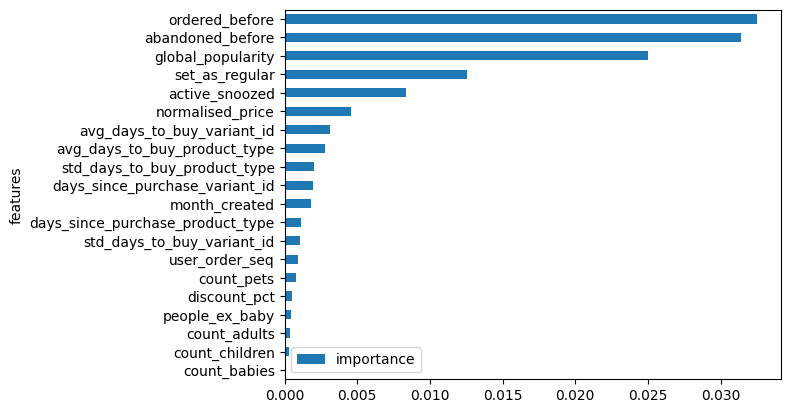

In [15]:
lr_coeff.plot(kind="barh", x="features", y="importance")

I’ll remove the last five features and retrain the Ridge model.

In [44]:
lr_filtered_cols = lr_coeff["features"].iloc[-15:]
lr_filtered_cols

7                           count_pets
0                       user_order_seq
11          std_days_to_buy_variant_id
12    days_since_purchase_product_type
15                       month_created
9       days_since_purchase_variant_id
14        std_days_to_buy_product_type
13        avg_days_to_buy_product_type
10          avg_days_to_buy_variant_id
1                     normalised_price
18                      active_snoozed
19                      set_as_regular
3                    global_popularity
17                    abandoned_before
16                      ordered_before
Name: features, dtype: object

In [ ]:
lr_ridge_train_aucs_list = []
lr_ridge_val_aucs_list = []
lr_ridge_train_aps_list = []
lr_ridge_val_aps_list = []
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    lr = make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=c))
    lr.fit(X_train[lr_filtered_cols], y_train)
    evaluate_model(
        lr,
        X_train[lr_filtered_cols],
        y_train,
        X_val[lr_filtered_cols],
        y_val,
        lr_ridge_train_aucs_list,
        lr_ridge_val_aucs_list,
        lr_ridge_train_aps_list,
        lr_ridge_val_aps_list,
    )

    print(
        f"LR Ridge c={c}: train_auc= {lr_ridge_train_aucs_list[-1]:.4f} and val_auc= {lr_ridge_val_aucs_list[-1]:.4f}."
        f" Train_ap= {lr_ridge_train_aps_list[-1]:.4f} and val_ap= {lr_ridge_val_aps_list[-1]:.4f}."
    )

LR Ridge c=1e-08: train_auc= 0.8249 and val_auc= 0.8323. Train_ap= 0.1563 and val_auc= 0.1603.
LR Ridge c=1e-06: train_auc= 0.8254 and val_auc= 0.8328. Train_ap= 0.1565 and val_auc= 0.1604.
LR Ridge c=0.0001: train_auc= 0.8118 and val_auc= 0.8244. Train_ap= 0.1602 and val_auc= 0.1585.
LR Ridge c=0.01: train_auc= 0.7982 and val_auc= 0.8131. Train_ap= 0.1585 and val_auc= 0.1560.
LR Ridge c=1: train_auc= 0.7980 and val_auc= 0.8129. Train_ap= 0.1585 and val_auc= 0.1559.
LR Ridge c=100: train_auc= 0.7980 and val_auc= 0.8129. Train_ap= 0.1585 and val_auc= 0.1559.
LR Ridge c=10000.0: train_auc= 0.7980 and val_auc= 0.8129. Train_ap= 0.1585 and val_auc= 0.1559.


The best result is still with c=1e-06, achieving a val_ap of 0.1604 (BASELINE)

# Decision trees

In [45]:
dt_train_aucs_list = []
dt_val_aucs_list = []
dt_train_aps_list = []
dt_val_aps_list = []
mds = [4, 5, 6, 8, 10]
for md in mds:
    dt = DecisionTreeClassifier(max_depth=md)
    dt.fit(X_train[train_cols], y_train)
    evaluate_model(
        dt,
        X_train[train_cols],
        y_train,
        X_val[train_cols],
        y_val,
        dt_train_aucs_list,
        dt_val_aucs_list,
        dt_train_aps_list,
        dt_val_aps_list,
    )

    print(
        f"Decision Tree max_depth={md}: train_auc= {dt_train_aucs_list[-1]:.4f} and val_auc= {dt_val_aucs_list[-1]:.4f}."
        f" Train_ap= {dt_train_aps_list[-1]:.4f} and val_ap= {dt_val_aps_list[-1]:.4f}."
    )

Decision Tree max_depth=4: train_auc= 0.8140 and val_auc= 0.8101. Train_ap= 0.1386 and val_ap= 0.1265.
Decision Tree max_depth=5: train_auc= 0.8171 and val_auc= 0.8182. Train_ap= 0.1549 and val_ap= 0.1457.
Decision Tree max_depth=6: train_auc= 0.8314 and val_auc= 0.8336. Train_ap= 0.1695 and val_ap= 0.1554.
Decision Tree max_depth=8: train_auc= 0.8384 and val_auc= 0.8366. Train_ap= 0.1924 and val_ap= 0.1595.
Decision Tree max_depth=10: train_auc= 0.8428 and val_auc= 0.8253. Train_ap= 0.2162 and val_ap= 0.1434.


With 'max_depth' = 10 it seems to appear overfitting because train_ap and val_ap take values with a difference of 0.06. The max_depth chosen have been 8

In [16]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train[train_cols], y_train)

DecisionTreeClassifier(max_depth=8)

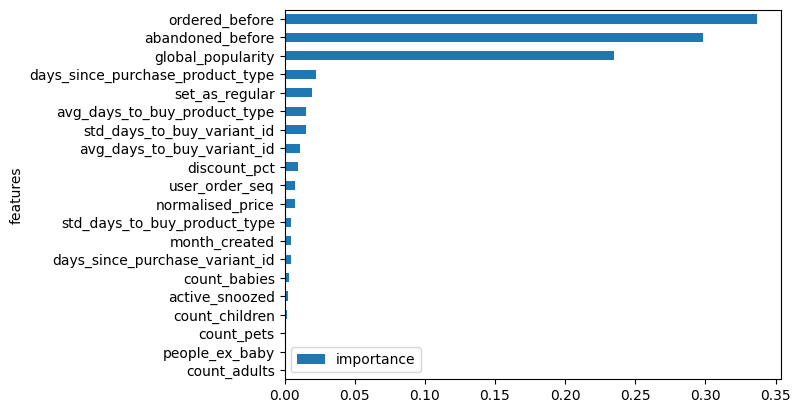

In [17]:
dt_fi, fig, ax = plot_feature_importance(dt, train_cols)

I'm going to drop the variables after 'count_babies'

In [18]:
dt_filtered_cols = [
    "abandoned_before",
    "active_snoozed",
    "global_popularity",
    "days_since_purchase_product_type",
    "std_days_to_buy_variant_id",
    "avg_days_to_buy_product_type",
    "avg_days_to_buy_variant_id",
    "discount_pct",
    "user_order_seq",
    "normalised_price",
    "days_since_purchase_variant_id",
    "std_days_to_buy_product_type",
]

In [20]:
dt_train_aucs_list = []
dt_val_aucs_list = []
dt_train_aps_list = []
dt_val_aps_list = []
mds = [4, 5, 6, 8, 10]
for md in mds:
    dt = DecisionTreeClassifier(max_depth=md)
    dt.fit(X_train[dt_filtered_cols], y_train)
    evaluate_model(
        dt,
        X_train[dt_filtered_cols],
        y_train,
        X_val[dt_filtered_cols],
        y_val,
        dt_train_aucs_list,
        dt_val_aucs_list,
        dt_train_aps_list,
        dt_val_aps_list,
    )

    print(
        f"Decision Tree max_depth={md}: train_auc= {dt_train_aucs_list[-1]:.4f} and val_auc= {dt_val_aucs_list[-1]:.4f}."
        f" Train_ap= {dt_train_aps_list[-1]:.4f} and val_ap= {dt_val_aps_list[-1]:.4f}."
    )

Decision Tree max_depth=4: train_auc= 0.7423 and val_auc= 0.7451. Train_ap= 0.1230 and val_ap= 0.1199.
Decision Tree max_depth=5: train_auc= 0.7996 and val_auc= 0.8056. Train_ap= 0.1413 and val_ap= 0.1406.
Decision Tree max_depth=6: train_auc= 0.8135 and val_auc= 0.8212. Train_ap= 0.1537 and val_ap= 0.1515.
Decision Tree max_depth=8: train_auc= 0.8248 and val_auc= 0.8286. Train_ap= 0.1757 and val_ap= 0.1635.
Decision Tree max_depth=10: train_auc= 0.8297 and val_auc= 0.8278. Train_ap= 0.1971 and val_ap= 0.1471.


The model with max_depth = 8 shows the best result once again, performing even better than without feature selection. This might mean that those dropped variables have deleted noise

# Random Forest

I'm going to try with maximun depth of the trees and different number of trees

In [185]:
rf_train_aucs_list = []
rf_val_aucs_list = []
rf_train_aps_list = []
rf_val_aps_list = []
n_trees = [5, 25, 50, 100, 120]
for n_tree in n_trees:
    rf = RandomForestClassifier(n_estimators=n_tree)
    rf.fit(X_train[train_cols], y_train)
    evaluate_model(
        rf,
        X_train[train_cols],
        y_train,
        X_val[train_cols],
        y_val,
        rf_train_aucs_list,
        rf_val_aucs_list,
        rf_train_aps_list,
        rf_val_aps_list,
    )

    print(
        f"Random Forest n_trees={n_tree}: train_auc= {rf_train_aucs_list[-1]:.4f} and val_auc= {rf_val_aucs_list[-1]:.4f}."
        f" Train_ap= {rf_train_aps_list[-1]:.4f} and val_ap= {rf_val_aps_list[-1]:.4f}."
    )

Random Forest n_trees=5: train_auc= 0.9900 and val_auc= 0.6530. Train_ap= 0.7722 and val_ap= 0.0824.
Random Forest n_trees=25: train_auc= 0.9953 and val_auc= 0.7360. Train_ap= 0.8543 and val_ap= 0.1318.
Random Forest n_trees=50: train_auc= 0.9957 and val_auc= 0.7579. Train_ap= 0.8617 and val_ap= 0.1405.
Random Forest n_trees=100: train_auc= 0.9958 and val_auc= 0.7769. Train_ap= 0.8650 and val_ap= 0.1474.
Random Forest n_trees=120: train_auc= 0.9959 and val_auc= 0.7800. Train_ap= 0.8653 and val_ap= 0.1463.


The best result is achieved with n_trees = 100. I’ll examine the feature importance for this configuration.

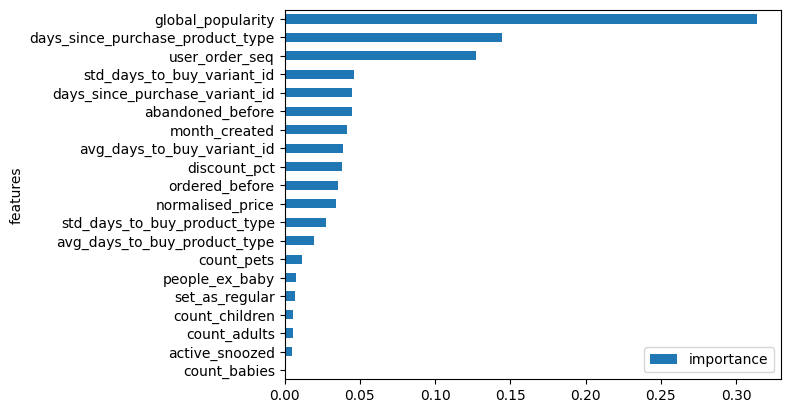

In [22]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train[train_cols], y_train)
rf_fi, fig, ax = plot_feature_importance(rf, train_cols)

I’ll remove the last five features and retrain the model.

In [24]:
rf_filtered_columns = rf_fi["features"].iloc[-14:]
rf_filtered_columns

7                           count_pets
13        avg_days_to_buy_product_type
14        std_days_to_buy_product_type
1                     normalised_price
16                      ordered_before
2                         discount_pct
10          avg_days_to_buy_variant_id
15                       month_created
17                    abandoned_before
9       days_since_purchase_variant_id
11          std_days_to_buy_variant_id
0                       user_order_seq
12    days_since_purchase_product_type
3                    global_popularity
Name: features, dtype: object

In [25]:
rf_train_aucs_list = []
rf_val_aucs_list = []
rf_train_aps_list = []
rf_val_aps_list = []
n_trees = [5, 25, 50, 100, 120]
for n_tree in n_trees:
    rf = RandomForestClassifier(n_estimators=n_tree)
    rf.fit(X_train[rf_filtered_columns], y_train)
    evaluate_model(
        rf,
        X_train[rf_filtered_columns],
        y_train,
        X_val[rf_filtered_columns],
        y_val,
        rf_train_aucs_list,
        rf_val_aucs_list,
        rf_train_aps_list,
        rf_val_aps_list,
    )

    print(
        f"Random Forest n_trees={n_tree}: train_auc= {rf_train_aucs_list[-1]:.4f} and val_auc= {rf_val_aucs_list[-1]:.4f}."
        f" Train_ap= {rf_train_aps_list[-1]:.4f} and val_ap= {rf_val_aps_list[-1]:.4f}."
    )

Random Forest n_trees=5: train_auc= 0.9901 and val_auc= 0.6402. Train_ap= 0.7626 and val_ap= 0.0747.
Random Forest n_trees=25: train_auc= 0.9950 and val_auc= 0.7193. Train_ap= 0.8462 and val_ap= 0.1177.
Random Forest n_trees=50: train_auc= 0.9954 and val_auc= 0.7449. Train_ap= 0.8539 and val_ap= 0.1256.
Random Forest n_trees=100: train_auc= 0.9956 and val_auc= 0.7665. Train_ap= 0.8570 and val_ap= 0.1297.
Random Forest n_trees=120: train_auc= 0.9956 and val_auc= 0.7703. Train_ap= 0.8576 and val_ap= 0.1311.


The performance has worsened after removing those variables.

# XGBoost

In [199]:
n_trees_grid = [100, 120, 150, 170, 200]
xg_train_aucs_list = []
xg_val_aucs_list = []
xg_train_aps_list = []
xg_val_aps_list = []

for lr in [0.05, 0.01]:
    for depth in [5, 7, 10, 12, 15]:
        for n_tree in n_trees_grid:
            xg = XGBClassifier(max_depth=depth, learning_rate=lr, n_estimators=n_tree)
            xg.fit(X_train[train_cols], y_train)
            evaluate_model(
                xg,
                X_train[train_cols],
                y_train,
                X_val[train_cols],
                y_val,
                xg_train_aucs_list,
                xg_val_aucs_list,
                xg_train_aps_list,
                xg_val_aps_list,
            )

            print(
                f"XGBoost n_trees={n_tree}, max_depth = {depth}, learning_rate = {lr} :"
                f"train_auc= {xg_train_aucs_list[-1]:.4f} and val_auc= {xg_val_aucs_list[-1]:.4f}."
                f" Train_ap= {xg_train_aps_list[-1]:.4f} and val_ap= {xg_val_aps_list[-1]:.4f}."
            )

XGBoost n_trees=100, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8441 and val_auc= 0.8460. Train_ap= 0.2112 and val_ap= 0.1965.
XGBoost n_trees=120, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8454 and val_auc= 0.8465. Train_ap= 0.2134 and val_ap= 0.1971.
XGBoost n_trees=150, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8470 and val_auc= 0.8469. Train_ap= 0.2160 and val_ap= 0.1973.
XGBoost n_trees=170, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8480 and val_auc= 0.8469. Train_ap= 0.2177 and val_ap= 0.1972.
XGBoost n_trees=200, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8492 and val_auc= 0.8466. Train_ap= 0.2207 and val_ap= 0.1972.
XGBoost n_trees=100, max_depth = 7, learning_rate = 0.05 :train_auc= 0.8497 and val_auc= 0.8475. Train_ap= 0.2358 and val_ap= 0.1996.
XGBoost n_trees=120, max_depth = 7, learning_rate = 0.05 :train_auc= 0.8512 and val_auc= 0.8475. Train_ap= 0.2390 and val_ap= 0.1991.
XGBoost n_trees=150, max_depth = 7, learning_rate = 0.05 :trai

I'll try using Random Search instead of Grid Search

In [202]:
n_trees = list(range(50, 300, 50))
lrs = [0.01, 0.05, 0.08, 0.1, 0.2]
depths = [5, 7, 10, 12, 15, 18, 20, 25, 30, 35]
n_iter = 50
xg_train_aucs_list = []
xg_val_aucs_list = []
xg_train_aps_list = []
xg_val_aps_list = []

for i in range(0, n_iter):
    lr = random.choice(lrs)
    depth = random.choice(depths)
    n_tree = random.choice(n_trees)
    xg = XGBClassifier(max_depth=depth, learning_rate=lr, n_estimators=n_tree)
    xg.fit(X_train[train_cols], y_train)
    evaluate_model(
        xg,
        X_train[train_cols],
        y_train,
        X_val[train_cols],
        y_val,
        xg_train_aucs_list,
        xg_val_aucs_list,
        xg_train_aps_list,
        xg_val_aps_list,
    )

    print(
        f"XGBoost n_trees={n_tree}, max_depth = {depth}, learning_rate = {lr} :"
        f"train_auc= {xg_train_aucs_list[-1]:.4f} and val_auc= {xg_val_aucs_list[-1]:.4f}."
        f" Train_ap= {xg_train_aps_list[-1]:.4f} and val_ap= {xg_val_aps_list[-1]:.4f}."
    )

XGBoost n_trees=250, max_depth = 5, learning_rate = 0.1 :train_auc= 0.8576 and val_auc= 0.8435. Train_ap= 0.2411 and val_ap= 0.1938.
XGBoost n_trees=150, max_depth = 12, learning_rate = 0.08 :train_auc= 0.8989 and val_auc= 0.8376. Train_ap= 0.3839 and val_ap= 0.1815.
XGBoost n_trees=150, max_depth = 12, learning_rate = 0.01 :train_auc= 0.8560 and val_auc= 0.8446. Train_ap= 0.2794 and val_ap= 0.1888.
XGBoost n_trees=250, max_depth = 12, learning_rate = 0.2 :train_auc= 0.9553 and val_auc= 0.8000. Train_ap= 0.5869 and val_ap= 0.1451.
XGBoost n_trees=50, max_depth = 15, learning_rate = 0.05 :train_auc= 0.8866 and val_auc= 0.8433. Train_ap= 0.3728 and val_ap= 0.1799.
XGBoost n_trees=150, max_depth = 15, learning_rate = 0.08 :train_auc= 0.9321 and val_auc= 0.8285. Train_ap= 0.4939 and val_ap= 0.1686.
XGBoost n_trees=150, max_depth = 20, learning_rate = 0.08 :train_auc= 0.9684 and val_auc= 0.8165. Train_ap= 0.6455 and val_ap= 0.1516.
XGBoost n_trees=200, max_depth = 15, learning_rate = 0.2 :t

The best result was achieved with n_trees = 100, max_depth = 7, and learning_rate = 0.05 with GridSearch. I'll examine the feature importance for this configuration.

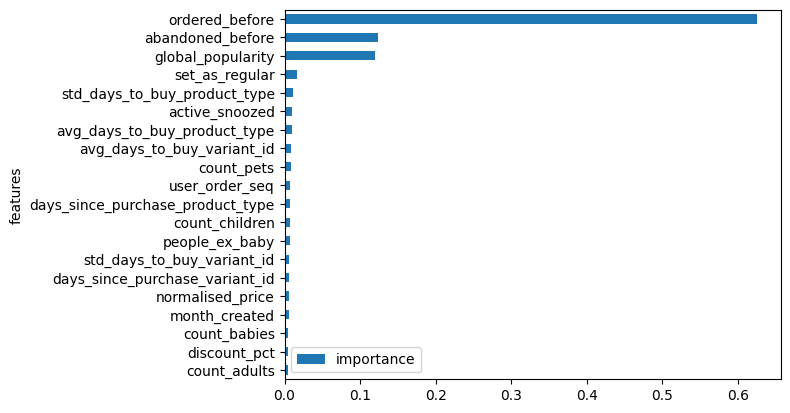

In [203]:
xg = XGBClassifier(learning_rate=0.05, max_depth=7, n_estimators=100)
xg.fit(X_train[train_cols], y_train)
xg_fi, fig, ax = plot_feature_importance(xg, train_cols)

In [209]:
xg_filtered_columns = xg_fi["features"].iloc[-15:]
xg_filtered_columns

9       days_since_purchase_variant_id
11          std_days_to_buy_variant_id
8                       people_ex_baby
5                       count_children
12    days_since_purchase_product_type
0                       user_order_seq
7                           count_pets
10          avg_days_to_buy_variant_id
13        avg_days_to_buy_product_type
18                      active_snoozed
14        std_days_to_buy_product_type
19                      set_as_regular
3                    global_popularity
17                    abandoned_before
16                      ordered_before
Name: features, dtype: object

In [210]:
n_trees_grid = [100, 120, 150, 170, 200]
xg_train_aucs_list = []
xg_val_aucs_list = []
xg_train_aps_list = []
xg_val_aps_list = []

for lr in [0.05, 0.01]:
    for depth in [5, 7, 10, 12, 15]:
        for n_tree in n_trees_grid:
            xg = XGBClassifier(max_depth=depth, learning_rate=lr, n_estimators=n_tree)
            xg.fit(X_train[xg_filtered_columns], y_train)
            evaluate_model(
                xg,
                X_train[xg_filtered_columns],
                y_train,
                X_val[xg_filtered_columns],
                y_val,
                xg_train_aucs_list,
                xg_val_aucs_list,
                xg_train_aps_list,
                xg_val_aps_list,
            )

            print(
                f"XGBoost n_trees={n_tree}, max_depth = {depth}, learning_rate = {lr} :"
                f"train_auc= {xg_train_aucs_list[-1]:.4f} and val_auc= {xg_val_aucs_list[-1]:.4f}."
                f" Train_ap= {xg_train_aps_list[-1]:.4f} and val_ap= {xg_val_aps_list[-1]:.4f}."
            )

XGBoost n_trees=100, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8435 and val_auc= 0.8456. Train_ap= 0.2092 and val_ap= 0.1970.
XGBoost n_trees=120, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8447 and val_auc= 0.8458. Train_ap= 0.2108 and val_ap= 0.1973.
XGBoost n_trees=150, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8457 and val_auc= 0.8457. Train_ap= 0.2128 and val_ap= 0.1969.
XGBoost n_trees=170, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8464 and val_auc= 0.8455. Train_ap= 0.2143 and val_ap= 0.1973.
XGBoost n_trees=200, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8473 and val_auc= 0.8452. Train_ap= 0.2166 and val_ap= 0.1969.
XGBoost n_trees=100, max_depth = 7, learning_rate = 0.05 :train_auc= 0.8481 and val_auc= 0.8459. Train_ap= 0.2310 and val_ap= 0.1988.
XGBoost n_trees=120, max_depth = 7, learning_rate = 0.05 :train_auc= 0.8492 and val_auc= 0.8456. Train_ap= 0.2330 and val_ap= 0.1979.
XGBoost n_trees=150, max_depth = 7, learning_rate = 0.05 :trai

Removing variables did not lead to an improvement in the metric, which remains at 0.1996.

# CatBoost

In [19]:
cat_features = categorical_cols
X_train.head(1)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,ordered_before,abandoned_before,active_snoozed,...,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,month_created
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,10


In [15]:
ca = CatBoostClassifier(max_depth=7, learning_rate=0.05, n_estimators=100, verbose=0)
ca.fit(X_train, y_train, cat_features)
pred_train = ca.predict_proba(X_train)[:, 1]
pred_val = ca.predict_proba(X_val)[:, 1]

In [12]:
n_trees_grid = [200, 210]
ca_train_aucs_list = []
ca_val_aucs_list = []
ca_train_aps_list = []
ca_val_aps_list = []

for lr in [0.05]:
    for depth in [5, 7]:
        for n_tree in n_trees_grid:
            ca = CatBoostClassifier(
                max_depth=depth, learning_rate=lr, n_estimators=n_tree, verbose=0
            )
            ca.fit(X_train, y_train, cat_features)
            evaluate_model(
                ca,
                X_train,
                y_train,
                X_val,
                y_val,
                ca_train_aucs_list,
                ca_val_aucs_list,
                ca_train_aps_list,
                ca_val_aps_list,
            )

            print(
                f"CatBoost n_trees={n_tree}, max_depth = {depth}, learning_rate = {lr} :"
                f"train_auc= {ca_train_aucs_list[-1]:.4f} and val_auc= {ca_val_aucs_list[-1]:.4f}."
                f" Train_ap= {ca_train_aps_list[-1]:.4f} and val_ap= {ca_val_aps_list[-1]:.4f}."
            )

CatBoost n_trees=200, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8437 and val_auc= 0.8450. Train_ap= 0.2146 and val_ap= 0.2012.
CatBoost n_trees=210, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8441 and val_auc= 0.8456. Train_ap= 0.2154 and val_ap= 0.2014.
CatBoost n_trees=200, max_depth = 7, learning_rate = 0.05 :train_auc= 0.8476 and val_auc= 0.8479. Train_ap= 0.2301 and val_ap= 0.2020.
CatBoost n_trees=210, max_depth = 7, learning_rate = 0.05 :train_auc= 0.8479 and val_auc= 0.8480. Train_ap= 0.2315 and val_ap= 0.2025.


# Curves of the best models

As I have already studied the best models taking into account to avoid overfitting, this curves represent the predictions with validation data for the best model of each type

In [35]:
lr = make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=1e-6))
lr.fit(X_train[lr_filtered_cols], y_train)
lr_predictions = lr.predict_proba(X_val[lr_filtered_cols])[:, 1]
print("LR Ridge trained with filtered columns")

dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train[dt_filtered_cols], y_train)
dt_predictions = dt.predict_proba(X_val[dt_filtered_cols])[:, 1]
print("Decission Tree trained with filtered columns")

rf = RandomForestClassifier(n_estimators=n_tree)
rf.fit(X_train[train_cols], y_train)
rf_predictions = rf.predict_proba(X_val[train_cols])[:, 1]
print("Random Forest trained with all the columns")

xg = XGBClassifier(max_depth=7, learning_rate=0.05, n_estimators=100)
xg.fit(X_train[train_cols], y_train)
xg_predictions = xg.predict_proba(X_val[train_cols])[:, 1]
print("XGBoost trained with all the columns")

ca = CatBoostClassifier(max_depth=7, learning_rate=0.05, n_estimators=210, verbose=0)
ca.fit(X_train, y_train, cat_features)
ca_predictions = ca.predict_proba(X_val)[:, 1]
print("CatBoost trained with all the columns")

LR Ridge trained with filtered columns
Decission Tree trained with filtered columns
Random Forest trained with all the columns
XGBoost trained with all the columns
CatBoost trained with all the columns


In [22]:
def get_info_curves(y_true, y_pred):
    precision, recall, pr_threshold = precision_recall_curve(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    fpr, tpr, roc_threashold = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return precision, recall, pr_threshold, fpr, tpr, roc_threashold, roc_auc, ap

In [37]:
(
    lr_precision,
    lr_recall,
    lr_pr_threshold,
    lr_fpr,
    lr_tpr,
    lr_roc_threshold,
    lr_roc_auc,
    lr_ap,
) = get_info_curves(y_val, lr_predictions)
(
    dt_precision,
    dt_recall,
    dt_pr_threshold,
    dt_fpr,
    dt_tpr,
    dt_roc_threshold,
    dt_roc_auc,
    dt_ap,
) = get_info_curves(y_val, dt_predictions)
(
    rf_precision,
    rf_recall,
    rf_pr_threshold,
    rf_fpr,
    rf_tpr,
    rf_roc_threshold,
    rf_roc_auc,
    rf_ap,
) = get_info_curves(y_val, rf_predictions)
(
    xg_precision,
    xg_recall,
    xg_pr_threshold,
    xg_fpr,
    xg_tpr,
    xg_roc_threshold,
    xg_roc_auc,
    xg_ap,
) = get_info_curves(y_val, xg_predictions)
(
    ca_precision,
    ca_recall,
    ca_pr_threshold,
    ca_fpr,
    ca_tpr,
    ca_roc_threshold,
    ca_roc_auc,
    ca_ap,
) = get_info_curves(y_val, ca_predictions)

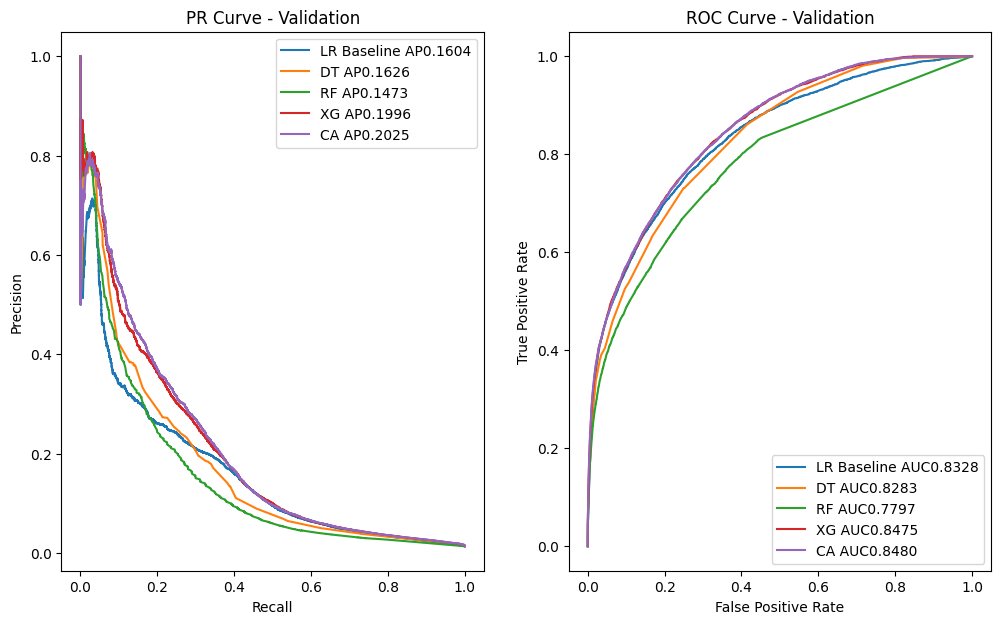

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
# Precision-Recall
ax[0].plot(lr_recall, lr_precision, label=f"LR Baseline AP{lr_ap:.4f}")
ax[0].plot(dt_recall, dt_precision, label=f"DT AP{dt_ap:.4f}")
ax[0].plot(rf_recall, rf_precision, label=f"RF AP{rf_ap:.4f}")
ax[0].plot(xg_recall, xg_precision, label=f"XG AP{xg_ap:.4f}")
ax[0].plot(ca_recall, ca_precision, label=f"CA AP{ca_ap:.4f}")
ax[0].set_title("PR Curve - Validation")
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].legend()

ax[1].plot(lr_fpr, lr_tpr, label=f"LR Baseline AUC{lr_roc_auc:.4f}")
ax[1].plot(dt_fpr, dt_tpr, label=f"DT AUC{dt_roc_auc:.4f}")
ax[1].plot(rf_fpr, rf_tpr, label=f"RF AUC{rf_roc_auc:.4f}")
ax[1].plot(xg_fpr, xg_tpr, label=f"XG AUC{xg_roc_auc:.4f}")
ax[1].plot(ca_fpr, ca_tpr, label=f"CA AUC{ca_roc_auc:.4f}")
ax[1].set_title("ROC Curve - Validation")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend()

It can be observed that CatBoost shows better performance across all Recall values, being only slightly superior to XGBoost. Taking CatBoost as the final model, it will be applied to the test subset, and a confusion matrix will be calculated for the operating point.

# Test subset

In [20]:
lr = make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=1e-6))
lr.fit(X_train[lr_filtered_cols], y_train)
lr_pred_test = lr.predict_proba(X_test[lr_filtered_cols])[:, 1]
ca = CatBoostClassifier(max_depth=7, learning_rate=0.05, n_estimators=210, verbose=0)
ca.fit(X_train, y_train, cat_features)
ca_pred_test = ca.predict_proba(X_test)[:, 1]

In [23]:
(
    lr_precision_t,
    lr_recall_t,
    lr_pr_threshold_t,
    lr_fpr_t,
    lr_tpr_t,
    lr_roc_threshold_t,
    lr_roc_auc_t,
    lr_ap_t,
) = get_info_curves(y_test, lr_pred_test)
(
    ca_precision_t,
    ca_recall_t,
    ca_pr_threshold_t,
    ca_fpr_t,
    ca_tpr_t,
    ca_roc_threshold_t,
    ca_roc_auc_t,
    ca_ap_t,
) = get_info_curves(y_test, ca_pred_test)

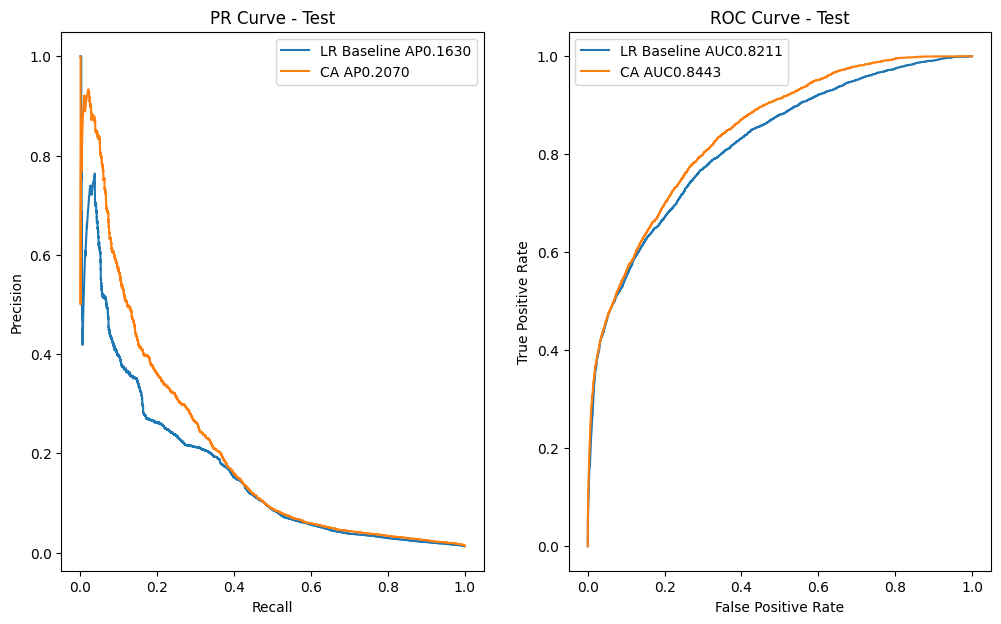

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
# Precision-Recall
ax[0].plot(lr_recall_t, lr_precision_t, label=f"LR Baseline AP{lr_ap_t:.4f}")
ax[0].plot(ca_recall_t, ca_precision_t, label=f"CA AP{ca_ap_t:.4f}")
ax[0].set_title("PR Curve - Test")
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].legend()

ax[1].plot(lr_fpr_t, lr_tpr_t, label=f"LR Baseline AUC{lr_roc_auc_t:.4f}")
ax[1].plot(ca_fpr_t, ca_tpr_t, label=f"CA AUC{ca_roc_auc_t:.4f}")
ax[1].set_title("ROC Curve - Test")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend()

Operating Point Recall = 0.2

In [41]:
target_recall = 0.2
idx = np.argmin(np.abs(ca_recall_t - target_recall))
selected_threshold = ca_pr_threshold_t[idx]
selected_precision = ca_precision_t[idx]
y_pred_binary = (ca_pred_test >= selected_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print(conf_matrix)

[[258873   1212]
 [  2714    678]]


Operating Point Recall = 0.3

In [43]:
target_recall = 0.3
idx = np.argmin(np.abs(ca_recall_t - target_recall))
selected_threshold = ca_pr_threshold_t[idx]
selected_precision = ca_precision_t[idx]
y_pred_binary = (ca_pred_test >= selected_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print(conf_matrix)

[[257215   2870]
 [  2374   1018]]


Since it is so important to reduce the number of false positives, as there is a risk of the application being uninstalled, I would choose the operating point with recall = 0.2, because increasing to a recall = 0.3 doubles the false positives.